# Processing COVID AMP dataset for analysis and visualization

## Import

In [1920]:
import pandas as pd
import numpy as np
from pyairtable import Table
from itertools import chain

import datetime as dt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import font_manager
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as md
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import geopandas
import pycountry
import time
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
base_key = 'appoXaOlIgpiHK3I2'
table_name = 'Policy Database'

# AIRTABLE API KEY -- DON'T COMMIT INTO GIT!
api_key = 'MY_AIRTABLE_KEY'

In [89]:
table = Table(api_key, base_key, table_name)

records = table.all()

In [190]:
full = pd.DataFrame.from_records((r['fields'] for r in records))

## Cleaning

In [191]:
# remove non-policy guidance
full = full.loc[full['Policy/law type'] != 'Non-policy guidance']

In [192]:
# drop rows missing key information
full = full.dropna(subset=['Unique ID',
                           'Policy category', 
                           'Policy description', 
                           'Authorizing country ISO'])

In [193]:
# drop down to a select number of relevant columns
cols = ['Unique ID','Issued date','Effective start date','Anticipated end date','Actual end date','Policy category','Policy subcategory', 'Policy target','Policy relaxing or restricting','Authorizing country ISO','Auth state names (lookup)']
full = full[cols]

In [194]:
# convert to datetime for indexing
full['Issued date'] = pd.to_datetime(full['Issued date'], format='%Y/%m/%d')
full['Effective start date'] = pd.to_datetime(full['Effective start date'], format='%Y/%m/%d')
full['Anticipated end date'] = pd.to_datetime(full['Anticipated end date'], format='%Y/%m/%d')
full['Actual end date'] = pd.to_datetime(full['Actual end date'], format='%Y/%m/%d')

In [195]:
# rename geo columns 
full = full.rename(columns={'Auth state names (lookup)': 'State', 'Authorizing country ISO':'Country'})

In [196]:
# remove brackets from state and country name
full['State'] = full['State'].astype(str)
full['State'] = full['State'].str.extract("\'(.*)\'")

full['Country'] = full['Country'].astype(str)
full['Country'] = full['Country'].str.extract("\'(.*)\'")

In [165]:
full.to_csv('processed/airtable_cleaned_033123.csv')

### Cases

In [1610]:
# Load and transform cases CSV
global_cases = pd.read_csv('cases/time_series_covid19_confirmed_global.csv')
global_cases = global_cases.drop(columns=['Province/State','Lat','Long'])
global_cases.set_index('Country/Region', inplace=True)
global_cases = global_cases.reset_index().melt(id_vars='Country/Region', var_name='Date', value_name='Cases')

exclude = ['Diamond Princess','Winter Olympics 2022']
global_cases = global_cases.loc[~global_cases['Country/Region'].isin(exclude)]

In [1611]:
# To datetime
global_cases['Date']= pd.to_datetime(global_cases['Date'])

# Global-level
global_cases = global_cases.groupby(['Date']).sum().reset_index()

In [1612]:
global_cases['New cases'] = global_cases['Cases'].diff().fillna(0)
global_cases['New cases per 100k'] = global_cases['New cases']/100000

In [1613]:
global_cases['7-day rolling average new cases'] = global_cases['New cases'].rolling(window=7).mean().reset_index(0,drop=True)

In [1614]:
global_cases = global_cases.dropna()
global_cases['7-day rolling average new cases'] = global_cases['7-day rolling average new cases'].astype(int)
global_cases['7-day rolling average new cases per 100k'] = global_cases['7-day rolling average new cases']/100000

In [1620]:
# Cut off for analysis
global_cases = global_cases.loc[global_cases['Date'] > '2019-12-31'].reset_index(drop=True)
global_cases = global_cases.loc[global_cases['Date'] < '2022-12-13'].reset_index(drop=True)

In [1661]:
# Load in and transform US data
us_cases = pd.read_csv('cases/time_series_covid19_confirmed_US.csv')
us_cases = us_cases.drop(columns=['UID','iso2','iso3','code3','FIPS','Admin2','Country_Region','Lat','Long_','Combined_Key'])
us_cases.set_index('Province_State', inplace=True)
us_cases = us_cases.reset_index().melt(id_vars='Province_State', var_name='Date', value_name='Cases')

In [1662]:
# To datetime
us_cases['Date'] = pd.to_datetime(us_cases['Date'])

# US-level
us_cases = us_cases.groupby(['Date']).sum().reset_index()

In [1664]:
us_cases['New cases'] = us_cases['Cases'].diff().fillna(0)
us_cases['New cases per 100k'] = us_cases['New cases']/100000

In [1665]:
us_cases['7-day rolling average new cases'] = us_cases['New cases'].rolling(window=7).mean().reset_index(0,drop=True)

In [1670]:
us_cases = us_cases.dropna()
us_cases['7-day rolling average new cases'] = us_cases['7-day rolling average new cases'].astype(int)
us_cases['7-day rolling average new cases per 100k'] = us_cases['7-day rolling average new cases']/100000

In [1681]:
# Cut off for analysis
us_cases = us_cases.loc[us_cases['Date'] > '2019-12-31'].reset_index(drop=True)
us_cases = us_cases.loc[us_cases['Date'] < '2022-12-13'].reset_index(drop=True)

## Visualizations

### Toolkit

In [405]:
clean = full.copy()

In [406]:
# Cut off for analysis
clean = clean.loc[clean['Effective start date'] > '2019-12-31'].reset_index(drop=True)
clean = clean.loc[clean['Effective start date'] < '2023-01-01'].reset_index(drop=True)


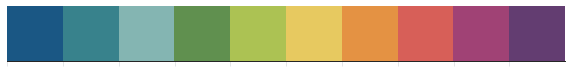

In [537]:
# Define rainbow color palette for categories
rainbow = {
    'Authorization and enforcement': '#1A5784',
    'Contact tracing/Testing': '#38828C',
    'Emergency declarations': '#84B5B2',
    'Enabling and relief measures':'#60904F',
    'Face mask':'#ACC253',
    'Military mobilization':'#E7C960',
    'Social distancing':'#E49243',
    'Support for public health and clinical capacity':'#D75F58',
    'Travel restrictions':'#A04275',
    'Vaccinations':'#633D71'
}

colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71']
sns.palplot(sns.color_palette(colors))



In [1046]:
# Define gradient color
gradient = ['#EEEFEF','#96CBD2','#147885']

cm = LinearSegmentedColormap.from_list(
        "Custom", gradient, N=100)

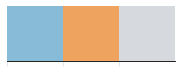

In [1701]:
# Define small color palette for relaxing/restricting
three = ['#87BBD8','#EEA45F','#D6D9DE']
sns.palplot(sns.color_palette(three))

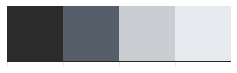

In [410]:
# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

In [1695]:
# Define constants
figure_size = (18,6)

# Define x-axis range
left = dt.date(2019, 10, 1)
right = dt.date(2023, 2, 1)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.9

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 12

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = -35
plt.rcParams["ytick.minor.pad"] = -35
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 12


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

### Figure 1

#### 1B: Category distribution of policies by month, global

In [566]:
# Count all policies in a given category, by month
global_cat_count = clean.groupby(['Policy category', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

In [567]:
global_cat_count['Effective start date']= global_cat_count['Effective start date']- pd.offsets.MonthBegin(1)

In [568]:
global_cat_count_pivot = global_cat_count.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy category', values='Policy count', fill_value=0)
global_cat_count_pivot = global_cat_count_pivot.reset_index().rename_axis(None, axis=1)

In [569]:
global_cat_count_pivot['Effective start date']= global_cat_count_pivot['Effective start date']- pd.offsets.MonthBegin(1)

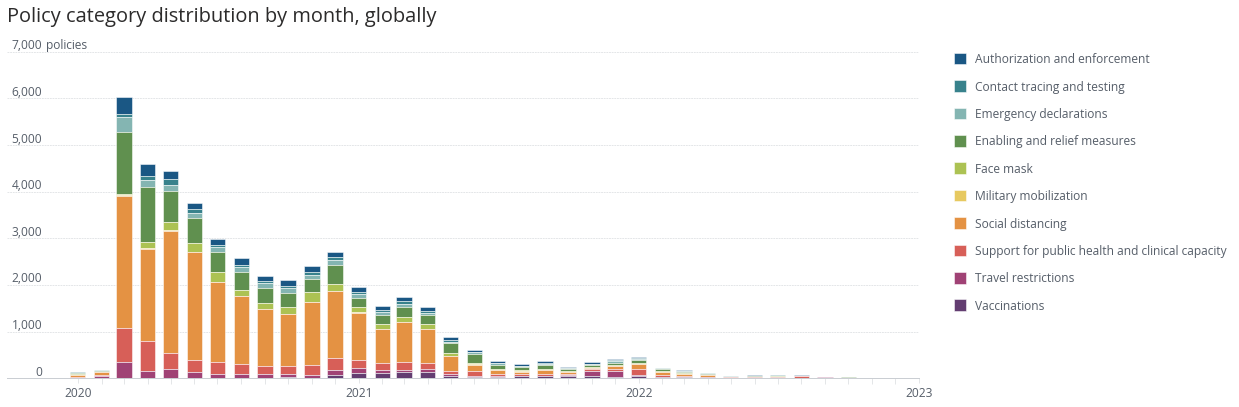

In [771]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=global_cat_count_pivot['Effective start date']
y1=global_cat_count_pivot['Authorization and enforcement']
y2=global_cat_count_pivot['Contact tracing/Testing']
y3=global_cat_count_pivot['Emergency declarations']
y4=global_cat_count_pivot['Enabling and relief measures']
y5=global_cat_count_pivot['Face mask']
y6=global_cat_count_pivot['Military mobilization']
y7=global_cat_count_pivot['Social distancing']
y8=global_cat_count_pivot['Support for public health and clinical capacity']
y9= global_cat_count_pivot['Travel restrictions']
y10 = global_cat_count_pivot['Vaccinations']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[0], label='Authorization and enforcement') 
plt.bar(x, y2, bottom=y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[1], label='Contact tracing and testing')
plt.bar(x, y3, bottom=y4+y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[2], label='Emergency declarations')
plt.bar(x, y4, bottom=y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[3], label='Enabling and relief measures')
plt.bar(x, y5, bottom=y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[4], label='Face mask')
plt.bar(x, y6, bottom=y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[5], label='Military mobilization')
plt.bar(x, y7, bottom=y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[6], label='Social distancing')
plt.bar(x, y8, bottom=y9+y10, linewidth=0.5,width=20, align="center", color=colors[7], label='Support for public health and clinical capacity')
plt.bar(x, y9, bottom=y10, linewidth=0.5,width=20, align="center", color=colors[8], label='Travel restrictions')
plt.bar(x, y10, bottom=0, linewidth=0.5, width=20, align="center", color=colors[9], label='Vaccinations')

ax.xaxis_date()

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,7000)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Policy category distribution by month, globally"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("policies", rotation=0,loc='top',labelpad=-80,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.35,1.03),labelcolor=chart[1],labelspacing=1.2)


plt.tight_layout()
plt.show()
# plt.savefig('figures/global_cat_per_month.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 1D: Category distribution of policies by month, US

In [779]:
us_cat_count = clean.loc[clean['Country'] == 'USA'].reset_index(drop=True)

In [781]:
# Count all policies in a given category, by month
us_cat_count = us_cat_count.groupby(['Policy category', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

In [782]:
us_cat_count['Effective start date']= us_cat_count['Effective start date']- pd.offsets.MonthBegin(1)

In [783]:
us_cat_count_pivot = us_cat_count.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy category', values='Policy count', fill_value=0)
us_cat_count_pivot = us_cat_count_pivot.reset_index().rename_axis(None, axis=1)

In [784]:
us_cat_count_pivot['Effective start date']= us_cat_count_pivot['Effective start date']- pd.offsets.MonthBegin(1)

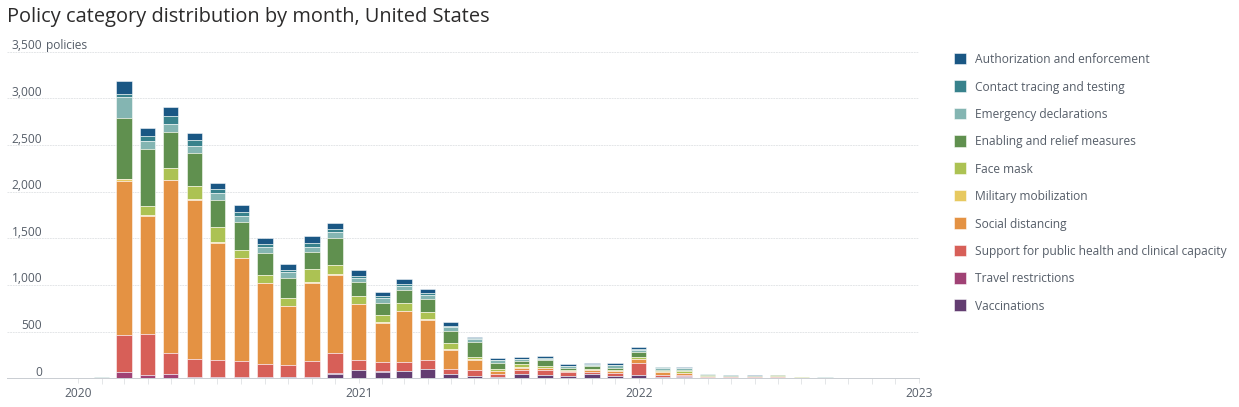

In [787]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=us_cat_count_pivot['Effective start date']
y1=us_cat_count_pivot['Authorization and enforcement']
y2=us_cat_count_pivot['Contact tracing/Testing']
y3=us_cat_count_pivot['Emergency declarations']
y4=us_cat_count_pivot['Enabling and relief measures']
y5=us_cat_count_pivot['Face mask']
y6=us_cat_count_pivot['Military mobilization']
y7=us_cat_count_pivot['Social distancing']
y8=us_cat_count_pivot['Support for public health and clinical capacity']
y9= us_cat_count_pivot['Travel restrictions']
y10 = us_cat_count_pivot['Vaccinations']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[0], label='Authorization and enforcement') 
plt.bar(x, y2, bottom=y3+y4+y5+y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[1], label='Contact tracing and testing')
plt.bar(x, y3, bottom=y4+y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[2], label='Emergency declarations')
plt.bar(x, y4, bottom=y5+y6+y7+y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[3], label='Enabling and relief measures')
plt.bar(x, y5, bottom=y6+y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[4], label='Face mask')
plt.bar(x, y6, bottom=y7+y8+y9+y10, linewidth=0.5, width=20, align="center", color=colors[5], label='Military mobilization')
plt.bar(x, y7, bottom=y8+y9+y10, linewidth=0.5,width=20, align="center", color=colors[6], label='Social distancing')
plt.bar(x, y8, bottom=y9+y10, linewidth=0.5,width=20, align="center", color=colors[7], label='Support for public health and clinical capacity')
plt.bar(x, y9, bottom=y10, linewidth=0.5,width=20, align="center", color=colors[8], label='Travel restrictions')
plt.bar(x, y10, bottom=0, linewidth=0.5, width=20, align="center", color=colors[9], label='Vaccinations')

ax.xaxis_date()

# Changes x-axis range
plt.gca().set_xbound(left, right)

# Changes y-axis range
plt.gca().set_ybound(0,3500)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Policy category distribution by month, United States"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Extend x-axis without showing labels
for label in ax.xaxis.get_ticklabels()[:1]:
    label.set_visible(False)
    
for x in ax.xaxis.get_major_ticks()[:1]:
    x.set_visible(False) 
    
for x in ax.xaxis.get_minor_ticks()[:3]:
    x.set_visible(False)

# Format y-axis label
plt.ylabel("policies", rotation=0,loc='top',labelpad=-80,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.35,1.03),labelcolor=chart[1],labelspacing=1.2)


plt.tight_layout()
plt.show()
# plt.savefig('figures/us_cat_per_month.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 1A: Total policies collected by country, globally

In [977]:
# Clean the clean df again
clean.loc[clean['Country'] == 'GB-ENG', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-NIR', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-SCT', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'GB-WLS', 'Country'] = 'GBR'
clean.loc[clean['Country'] == 'SXC', 'Country'] = 'KNA'

# Count all policies in a given country
global_count = clean.groupby(['Country']).size().reset_index(name="Policy count")

In [978]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world.rename(columns={"iso_a3":"Country"})
cols = ['name','Country','geometry']
world = world[cols]
world = world.sort_values(by="Country")

In [979]:
# Fix issues in geopandas
world.loc[world['name'] == 'France', 'Country'] = 'FRA'
world.loc[world['name'] == 'Norway', 'Country'] = 'NOR'
world.loc[world['name'] == 'Somaliland', 'Country'] = 'SOM'
world.loc[world['name'] == 'Kosovo', 'Country'] = 'RKS'

In [980]:
# Add countries to geopandas
new_country = pd.DataFrame({'name': ['Aruba','American Samoa','Antigua and Barbuda','Bahrain','Curaçao','Cayman Islands','Hong Kong','Saint Kitts and Nevis','Macao','Maldives','Marshall Islands','Malta','Mauritius','Palau','Singapore','Seychelles','Tuvalu','Saint Vincent and the Grenadines','Samoa'], 
                            'Country': ['ABW','ASW','ATG','BHR','CUW','CYM','HKG','KNA','MAC','MDV','MHL','MLT','MUS','PLW','SGP','SYC','TUV','VCT','WSM']})
world = world.append(new_country, ignore_index=True)


In [981]:
merge = pd.merge(world,global_count,on='Country',how='outer')
merge['Policy count'] = merge['Policy count'].fillna(0)
merge['Policy count'] = merge['Policy count'].astype('int')
merge = merge[(merge.name != "Antarctica")]

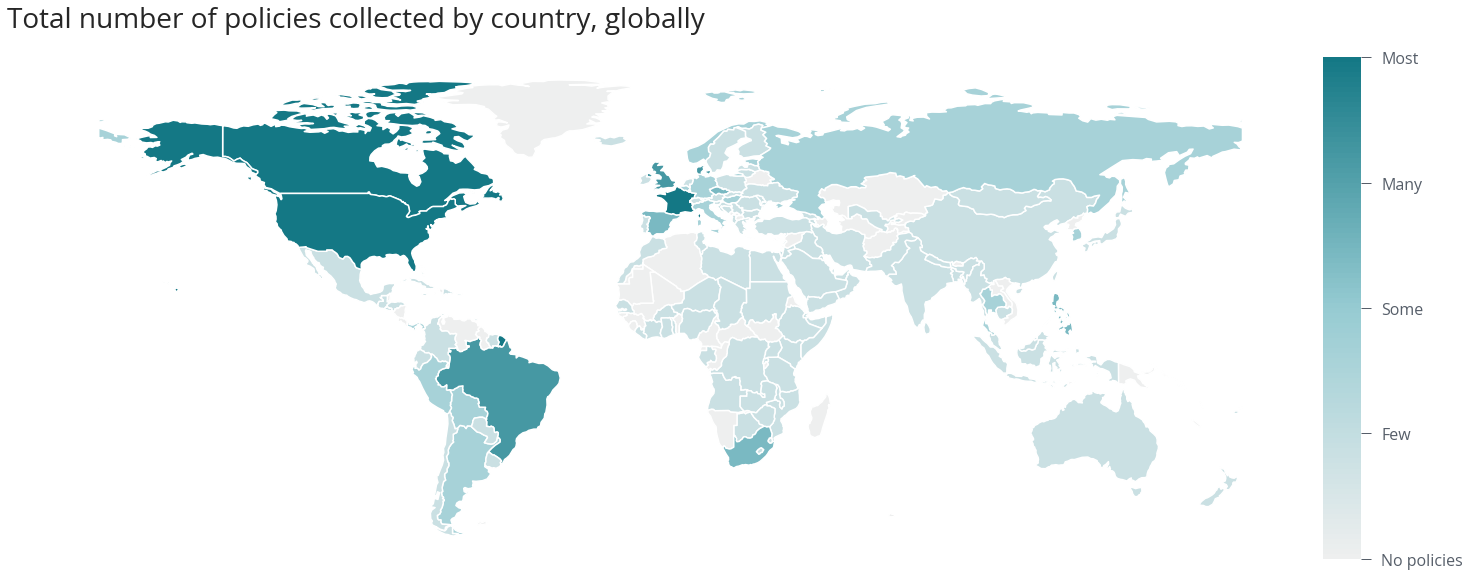

In [1143]:
# Set colorbar min and max values
vmin=merge['Policy count'].min()
vmax=merge['Policy count'].max()
vmid=((vmax+vmin)/2)
vq1=((vmin+vmid)/2)
vq3=((vmid+vmax)/2)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(24, 18))

fig.subplots_adjust(hspace=0.0, wspace=0.0)

# Plot the map
merge.plot(column='Policy count',
           cmap=cm,
           scheme='User_Defined',
           legend=False,
           classification_kwds=dict(bins=[0,250,500,750,1000]),
           ax=ax
          )

# Adjust margins and set title
ax.margins(x=0.05) 

ttl = ax.set_title('Total number of policies collected by country, globally',fontsize=28)
ttl.set_position([0.25,1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))


sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False)
cbar.set_ticks([vmin,vq1,vmid,vq3,vmax])
cbar.ax.yaxis.set_ticklabels(['No policies','Few','Some','Many','Most'])
cbar.ax.yaxis.set_tick_params(direction='out',length=10,width=1,pad=10,colors=chart[1],labelsize=16)
cbar.outline.set_visible(False)


# Display the map
plt.show()

# # Save
# plt.savefig('figures/total_global_policies.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 1C: Total policies collected by state, United States

In [1186]:
# Filter to US, count policies by state
state_count = clean.loc[clean['Country']=='USA']
state_count = state_count.groupby(['State']).size().reset_index(name="Policy count")
# state_count = state_count.loc[(state_count["State"]!="Guam")&(state_count["State"]!="Puerto Rico")]

In [1187]:
usa = geopandas.read_file('spatial/states')

In [1188]:
usa = usa.rename(columns={"NAME":"State"})
cols = ['State','geometry']
usa = usa[cols]
usa = usa.sort_values(by="State")

In [1189]:
us_merge = pd.merge(usa,state_count,on='State',how='inner')
us_merge['Policy count'] = us_merge['Policy count'].fillna(0)
us_merge['Policy count'] = us_merge['Policy count'].astype('int')

In [1202]:
# Filter data for mainland and non-mainland territories
not_mainland = ['Alaska', 'Hawaii', "Puerto Rico","Guam"]
not_mainland = us_merge[us_merge['State'].isin(not_mainland)]
mainland = us_merge[~us_merge['State'].isin(not_mainland)]

hawaii = not_mainland.loc[(not_mainland["State"]=="Hawaii")]
alaska = not_mainland.loc[(not_mainland["State"]=="Alaska")]

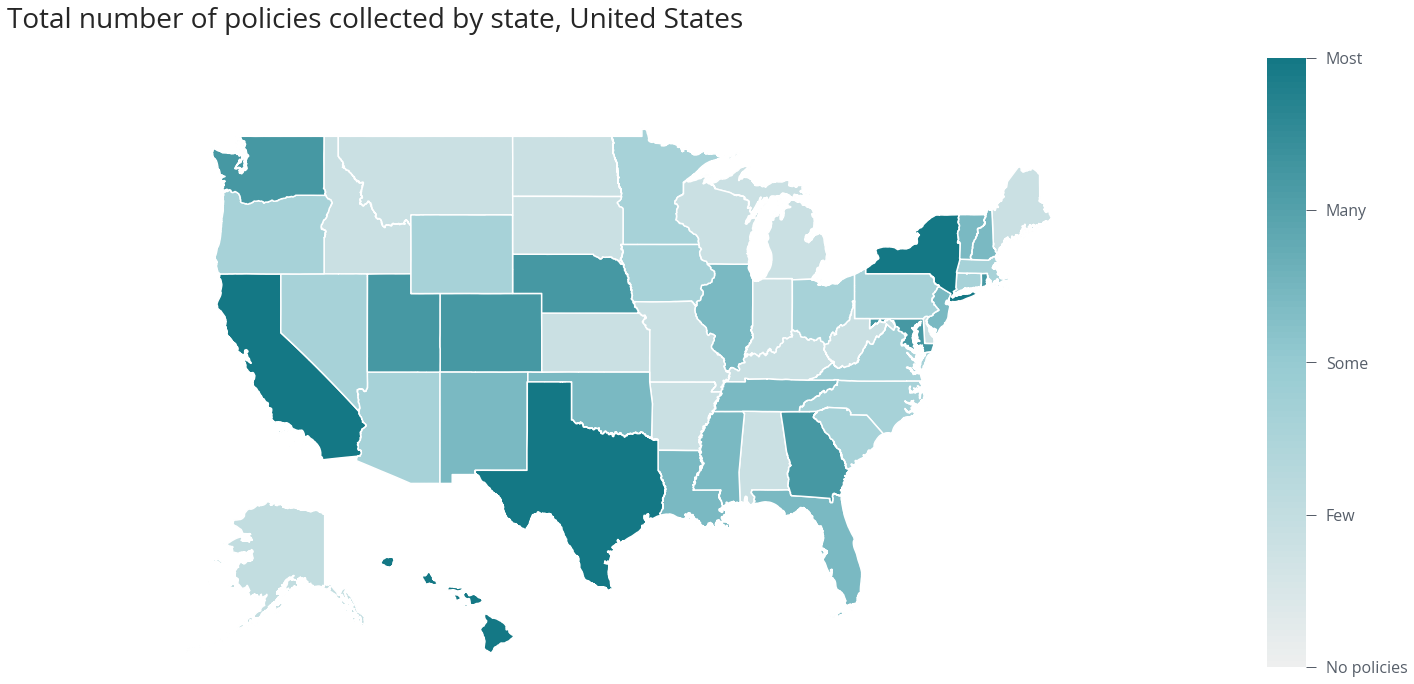

In [1218]:
# Set colorbar min and max values
vmin=0
vmax=us_merge['Policy count'].max()
vmid=((vmax+vmin)/2)
vq1=((vmin+vmid)/2)
vq3=((vmid+vmax)/2)

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(24, 18))

# Set bounds to fit desired areas in each plot
ax.set_xlim(-130, -64)
ax.set_ylim(22, 53)

fig.subplots_adjust(hspace=0.0, wspace=0.0)

# Plot the mainland map
mainland.plot(column='Policy count',
           cmap=cm,
           scheme='User_Defined',
           legend=False,
           classification_kwds=dict(bins=[0,250,500,750,1000]),
           ax=ax
          )

# Adjust margins and set title
ax.margins(x=0.05) 

ttl = ax.set_title('Total number of policies collected by state, United States',fontsize=28)
ttl.set_position([0.25,1.05])

# Set the background color of the map
ax.set(facecolor='white')

# Turn axis off
ax.axis('off')

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))


sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False)
cbar.set_ticks([vmin,vq1,vmid,vq3,vmax])
cbar.ax.yaxis.set_ticklabels(['No policies','Few','Some','Many','Most'])
cbar.ax.yaxis.set_tick_params(direction='out',length=10,width=1,pad=10,colors=chart[1],labelsize=16)
cbar.outline.set_visible(False)

# Create an axis with 2 insets for Alaska and Hawaii
alaska_ax = ax.inset_axes([.05, .01, .20, .28])
hawaii_ax = ax.inset_axes([.25, .01, .15, .19])

alaska_ax.set_ylim(51, 72)
alaska_ax.set_xlim(-180, -127)

hawaii_ax.set_ylim(18.8, 22.5)
hawaii_ax.set_xlim(-160, -154.6)


# Plot Hawaii map
hawaii.plot(column='Policy count',
            cmap=cm,
            scheme='User_Defined',
            legend=False,
            classification_kwds=dict(bins=[0,250,500,750,1000]),
            ax=hawaii_ax)
hawaii_ax.margins(x=0.05)
hawaii_ax.set(facecolor='white')
hawaii_ax.axis('off')

# Plot Alaska map
alaska.plot(column='Policy count',
            cmap=cm,
            scheme='User_Defined',
            legend=False,
            classification_kwds=dict(bins=[0,250,500,750,1000]),
            ax=alaska_ax)
alaska_ax.margins(x=0.05)
alaska_ax.set(facecolor='white')
alaska_ax.axis('off')

# Display the map
plt.tight_layout()
plt.show()

# # Save
# plt.savefig('figures/total_us_policies.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

### Figure 2

#### 2A: Type of policy over time, compared to caseload, global

In [1250]:
# Count all policies of a given type, by month
global_type = clean.groupby(['Policy relaxing or restricting', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

# Calculate total policies by month
total_policies = global_type.groupby(pd.Grouper(key='Effective start date', freq='M'))['Policy count'].sum().reset_index(name='Total policies')

# Merge total_policies back into the original dataframe
global_type = pd.merge(global_type, total_policies, on='Effective start date')

# Calculate percent
global_type['Percent'] = (global_type['Policy count'] / global_type['Total policies'])


In [1251]:
global_type['Effective start date']= global_type['Effective start date']- pd.offsets.MonthBegin(1)

In [1252]:
global_type_pivot = global_type.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy relaxing or restricting', values='Percent', fill_value=0)
global_type_pivot = global_type_pivot.reset_index().rename_axis(None, axis=1)

In [1253]:
global_type_pivot['Effective start date']= global_type_pivot['Effective start date']- pd.offsets.MonthBegin(1)

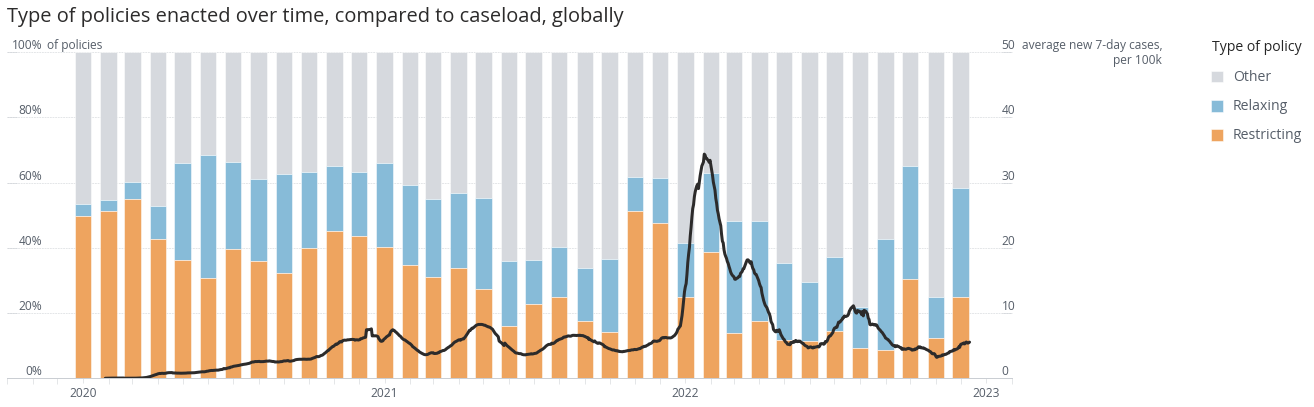

In [1705]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=global_type_pivot['Effective start date']
y1 = global_type_pivot['Other']
y2 = global_type_pivot['Relaxing']
y3 = global_type_pivot['Restricting']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3, linewidth=0.5, width=20, align="center", color=three[2], label='Other') 
plt.bar(x, y2, bottom=y3, linewidth=0.5, width=20, align="center", color=three[0], label='Relaxing')
plt.bar(x, y3, bottom=0, linewidth=0.5, width=20, align="center", color=three[1], label='Restricting')

ax.xaxis_date()

# Changes x-axis range
ax.set_xlim(left,right)

# Changes y-axis range
ax.set_ylim(0,1)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Type of policies enacted over time, compared to caseload, globally"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Format y-axis label
plt.ylabel("of policies", rotation=0,loc='top',labelpad=-95,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.30,1.07),labelcolor=chart[1],labelspacing=1.2)
leg.set_title('Type of policy')
leg.get_title().set_fontsize('14') 
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 

# Create secondary y-axis
ax2 = ax.twinx()
ax2.xaxis_date()

# Format bottom axis
for axis in ['bottom']:
    ax2.spines[axis].set_color(chart[2])

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax2.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax2.xaxis.set_tick_params(which='minor', labelbottom=False)

# Plot line graph on secondary axis
x2 = global_cases['Date']
y4 = global_cases['7-day rolling average new cases per 100k']
ax2.plot(x2, y4, color=chart[0], linewidth=3.0, label='Cases')

# Set y-axis label for secondary axis
plt.ylabel("average new 7-day cases,\nper 100k", rotation=0, loc='top',color=chart[1])
ax2.yaxis.set_label_coords(1.15, 1.04) # adjust position of label
for tick in ax2.get_yticklabels():
    tick.set_verticalalignment("bottom")
ax2.tick_params(axis='y', direction='in', pad=-10)

# Set y-axis range for secondary axis
ax2.set_ylim(0, 50)

# plt.tight_layout()
# plt.show()


plt.savefig('figures/global_policy_type_cases.svg', dpi=1200, facecolor='w', 
            edgecolor='w', 
            orientation='portrait',bbox_inches='tight')

#### 2C: Type of policy over time, compared to caseload, U.S.

In [1672]:
# Count all policies of a given type, by month
us_type = clean.groupby(['Policy relaxing or restricting', pd.Grouper(key='Effective start date', freq='M')]).size().reset_index(name="Policy count")

# Calculate total policies by month
total_policies_us = us_type.groupby(pd.Grouper(key='Effective start date', freq='M'))['Policy count'].sum().reset_index(name='Total policies')

# Merge total_policies back into the original dataframe
us_type = pd.merge(us_type, total_policies_us, on='Effective start date')

# Calculate percent
us_type['Percent'] = (us_type['Policy count'] / us_type['Total policies'])


In [1674]:
us_type['Effective start date']= us_type['Effective start date']- pd.offsets.MonthBegin(1)

In [1676]:
us_type_pivot = us_type.pivot_table(index=pd.Grouper(key='Effective start date', freq='M'), columns='Policy relaxing or restricting', values='Percent', fill_value=0)
us_type_pivot = us_type_pivot.reset_index().rename_axis(None, axis=1)

In [1677]:
us_type_pivot['Effective start date']= us_type_pivot['Effective start date']- pd.offsets.MonthBegin(1)

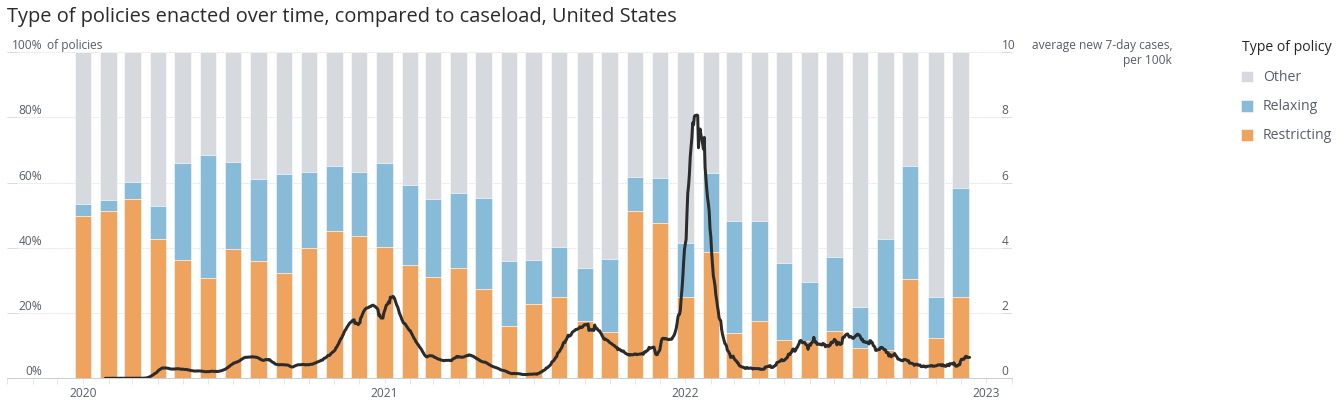

In [1713]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(False)

# Format bottom axis
for axis in ['bottom']:
    ax.spines[axis].set_color(chart[2])
    
# Add grid lines    
plt.grid(axis='y')


# Define variables
x=us_type_pivot['Effective start date']
y1 = us_type_pivot['Other']
y2 = us_type_pivot['Relaxing']
y3 = us_type_pivot['Restricting']

# Plot bars
# The thing that gets plotted last in this list gets plotted on the bottom

plt.bar(x, y1, bottom=y2+y3, linewidth=0.5, width=20, align="center", color=three[2], label='Other') 
plt.bar(x, y2, bottom=y3, linewidth=0.5, width=20, align="center", color=three[0], label='Relaxing')
plt.bar(x, y3, bottom=0, linewidth=0.5, width=20, align="center", color=three[1], label='Restricting')

ax.xaxis_date()

# Changes x-axis range
ax.set_xlim(left,right)

# Changes y-axis range
ax.set_ylim(0,1)

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax.xaxis.set_tick_params(which='minor', labelbottom=False)

# Set title
title = "Type of policies enacted over time, compared to caseload, United States"
plt.title(title, fontdict=titlefont, loc='left')

# Set x-axis label
plt.xlabel("")

# Format y-axis label
plt.ylabel("of policies", rotation=0,loc='top',labelpad=-95,color=chart[1])
for tick in ax.get_yticklabels():
    tick.set_verticalalignment("bottom")
    
# after plotting the data, format the labels
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.0%}'.format(x) for x in current_values])


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.33,1.07),labelcolor=chart[1],labelspacing=1.2)
leg.set_title('Type of policy')
leg.get_title().set_fontsize('14') 
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14') 

# Create secondary y-axis
ax2 = ax.twinx()
ax2.xaxis_date()

# Format bottom axis
for axis in ['bottom']:
    ax2.spines[axis].set_color(chart[2])

# Set major and minor date tick locators
maj_loc = mdates.YearLocator()
ax2.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax2.xaxis.set_minor_locator(min_loc)

# Set major date tick formatter
maj_fmt = mdates.DateFormatter('%Y')
ax2.xaxis.set_major_formatter(maj_fmt)

# Hide minor tick labels
ax2.xaxis.set_tick_params(which='minor', labelbottom=False)

# Plot line graph on secondary axis
x2 = us_cases['Date']
y4 = us_cases['7-day rolling average new cases per 100k']
ax2.plot(x2, y4, color=chart[0], linewidth=3.0, label='Cases')

# Set y-axis label for secondary axis
plt.ylabel("average new 7-day cases,\nper 100k", rotation=0, loc='top',color=chart[1])
ax2.yaxis.set_label_coords(1.16, 1.04) # adjust position of label
for tick in ax2.get_yticklabels():
    tick.set_verticalalignment("bottom")
ax2.tick_params(axis='y', direction='in', pad=-10)

# Set y-axis range for secondary axis
ax2.set_ylim(0, 10)

plt.tight_layout()
plt.show()

# plt.savefig('figures/us_policy_type.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 2B: Type of policy by category, global

In [1725]:
# Count all policies of a given type, by category
global_tcat = clean.groupby(['Policy relaxing or restricting', pd.Grouper(key='Policy category')]).size().reset_index(name="Policy count")

# Calculate total policies by category
total_pols = global_tcat.groupby(pd.Grouper(key='Policy category'))['Policy count'].sum().reset_index(name='Total policies')

# Merge total_policies back into the original dataframe
global_tcat = pd.merge(global_tcat, total_pols, on='Policy category')

# Calculate percent
global_tcat['Percent'] = (global_tcat['Policy count'] / global_tcat['Total policies'])

# Sort
global_tcat = global_tcat.sort_values(by=["Policy relaxing or restricting","Policy category"],ascending=[False,False])

In [1768]:
colordict = {"Restricting":three[1],"Relaxing":three[0],"Other":three[2]}
colors = [colordict[cat] for cat in global_tcat['Policy relaxing or restricting']]

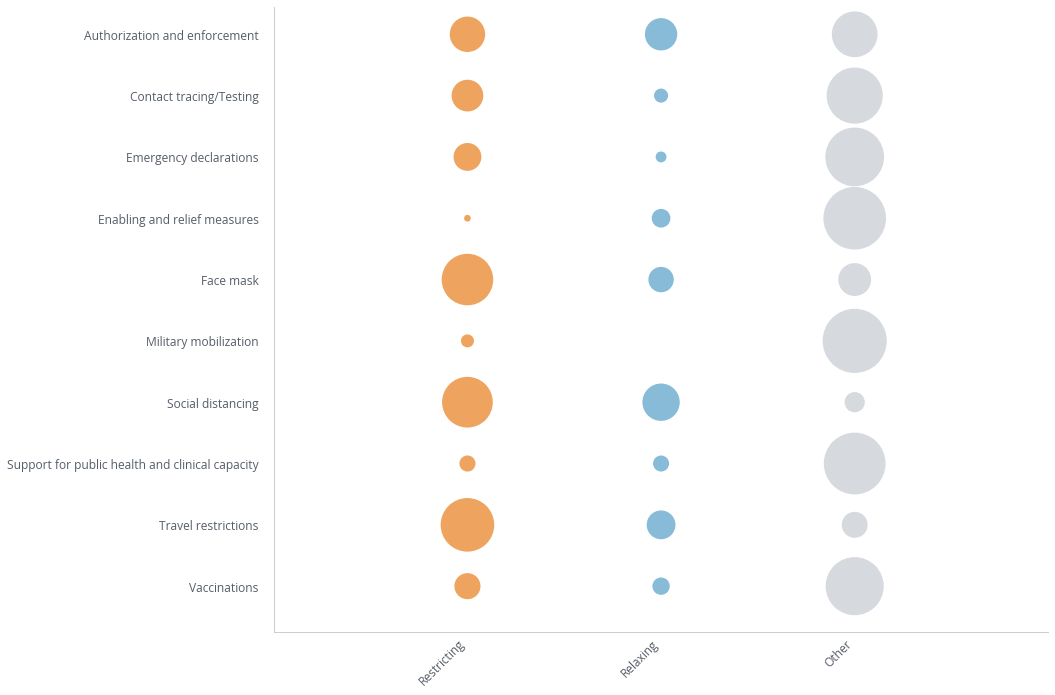

In [2059]:
# Format figure
fig, ax1 = plt.subplots(figsize=(15, 10))

# Turn on left spine
ax1.spines.left.set_visible(True)

ax1.set_xlim([-1, 3])

# Format bottom axis
for axis in ['bottom','left']:
    ax1.spines[axis].set_color(chart[2])
    
# Normalize the data
norm = Normalize(vmin=global_tcat['Percent'].min(), vmax=global_tcat['Percent'].max())
sizes = norm(global_tcat['Percent']) * (vmax-vmin) + vmin

# Plot the data
x = global_tcat['Policy relaxing or restricting']
y = global_tcat['Policy category']
sc = ax1.scatter(x=x, 
            y=y, 
            s=sizes,
            c=colors,
            alpha=1)

# Set x and y limits with padding
ax1.set_ylim(ymin=-0.75)

# Set x-ticks
ax1.tick_params(axis='x', which='both', length=0, pad=5,color=chart[1])
labels = global_tcat['Policy relaxing or restricting'].unique()
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Set y-ticks
ax1.tick_params(axis='y',direction='out',pad=5,color=chart[1])

# # Define legend sizes and labels
# sizes_legend = [196,980,1961,vmax]
# labels_legend = ['>5% of policies', '25%','50%', '100%']
# i = [1,0,2,1]

# # Create empty scatter plots with desired sizes and labels
# legend_plots = []
# for size, label, i in zip(sizes_legend, labels_legend, i):
#     legend_plots.append(ax1.scatter([], [], s=size, label=label, color=three[2], alpha=0.5))


# ax1.legend(handles=legend_plots,
#            bbox_to_anchor=(1.05,1.03),
#            labelcolor=chart[1],
#            frameon=True,
#            fancybox=True,
#            ncol=1, 
#            labelspacing=0.8,
#            handletextpad=2)


plt.tight_layout()
plt.show()


# plt.savefig('figures/global_policy_type_cats.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 2B: Alternate

In [2086]:
global_tcat_pivot = global_tcat.pivot_table(index=pd.Grouper(key='Policy category'), columns='Policy relaxing or restricting', values='Percent', fill_value=0)
global_tcat_pivot = global_tcat_pivot.reset_index().rename_axis(None, axis=1)

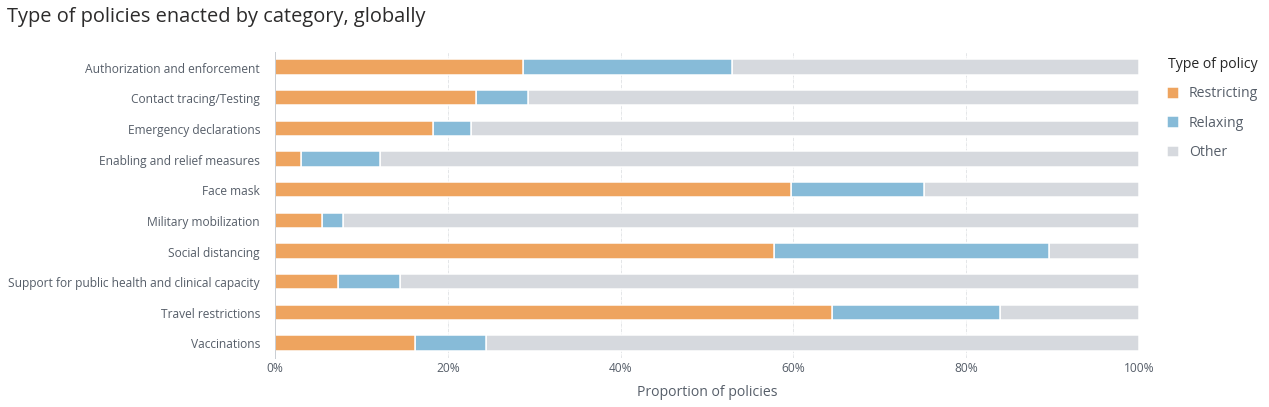

In [2164]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(False)


# Format left axis
for axis in ['left']:
    ax.spines[axis].set_color(chart[2])

# Define variables
y = global_tcat_pivot['Policy category']
x1 = global_tcat_pivot['Other']
x2 = global_tcat_pivot['Relaxing']
x3 = global_tcat_pivot['Restricting']
cats = y.unique().tolist()

# Set colors
three2 = ['#D6D9DE','#87BBD8','#EEA45F']

# Plot data
global_tcat_pivot.plot.barh(stacked=True, color=three2,width = 0.5,ax=ax)

# Changes x-axis range
ax.set_xlim(0, 1)

ax.grid(axis='x', linestyle='-.', linewidth=0.5, color=chart[2], zorder=1)

# Reverse order of axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


# Set title
title = "Type of policies enacted by category, globally"
plt.title(title, fontdict=titlefont, loc='left',x=-0.31)

# Set y-ticks
ax.set_yticklabels(cats)
ax.tick_params(axis='y',direction='out',pad=5,color=chart[1])

# Set y-axis label
plt.ylabel("")

# Format x-axis label
plt.xlabel("Proportion of policies", labelpad=10, color=chart[1],fontsize=14)
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment("center")

# Format x-ticks
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values[::-1]])
ax.tick_params(axis='x',direction='in',length=0)


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(1.02, 1.02), labelcolor=chart[1], labelspacing=1.2)
leg.set_title('Type of policy')
leg.get_title().set_fontsize('14')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14')

plt.tight_layout()
plt.show()

# plt.savefig('figures/global_policy_type_bar.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')


#### 2D: Type of policy by category, United States

In [2065]:
# Count all policies of a given type, by category
us_tcat = clean.loc[clean['Country']=='USA']
us_tcat = us_tcat.groupby(['Policy relaxing or restricting', pd.Grouper(key='Policy category')]).size().reset_index(name="Policy count")

# Calculate total policies by category
us_total_pols = us_tcat.groupby(pd.Grouper(key='Policy category'))['Policy count'].sum().reset_index(name='Total policies')

# Merge total_policies back into the original dataframe
us_tcat = pd.merge(us_tcat, us_total_pols, on='Policy category')

# Calculate percent
us_tcat['Percent'] = (us_tcat['Policy count'] / us_tcat['Total policies'])

us_tcat = us_tcat.sort_values(by=["Policy relaxing or restricting","Policy category"],ascending=[False,False])

In [2067]:
colordict = {"Restricting":three[1],"Relaxing":three[0],"Other":three[2]}
colors = [colordict[cat] for cat in us_tcat['Policy relaxing or restricting']]

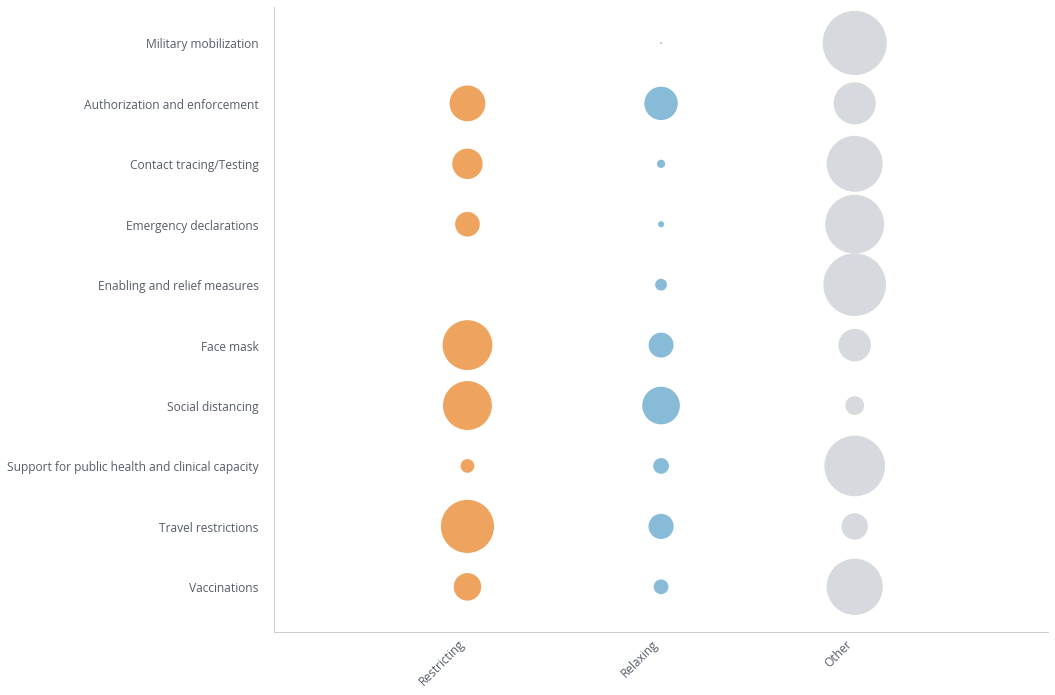

In [2074]:
# Format figure
fig, ax1 = plt.subplots(figsize=(15, 10))

# Turn on left spine
ax1.spines.left.set_visible(True)

ax1.set_xlim([-1, 3])

# Format bottom axis
for axis in ['bottom','left']:
    ax1.spines[axis].set_color(chart[2])
    
# Normalize the data
norm = Normalize(vmin=us_tcat['Percent'].min(), vmax=us_tcat['Percent'].max())
sizes = norm(us_tcat['Percent']) * (vmax-vmin) + vmin

# Plot the data
x = us_tcat['Policy relaxing or restricting']
y = us_tcat['Policy category']
sc = ax1.scatter(x=x, 
            y=y, 
            s=sizes,
            c=colors,
            alpha=1)

# Set x and y limits with padding
ax1.set_ylim(ymin=-0.75,ymax=9.6)

# Set x-ticks
ax1.tick_params(axis='x', which='both', length=0, pad=5,color=chart[1])
labels = global_tcat['Policy relaxing or restricting'].unique()
ax1.set_xticks([0,1,2])
ax1.set_xticklabels(labels, rotation=45, ha='right')

# Set y-ticks
ax1.tick_params(axis='y',direction='out',pad=5,color=chart[1])

# # Define legend sizes and labels
# sizes_legend = [196,980,1961,vmax]
# labels_legend = ['>5% of policies', '25%','50%', '100%']
# i = [1,0,2,1]

# # Create empty scatter plots with desired sizes and labels
# legend_plots = []
# for size, label, i in zip(sizes_legend, labels_legend, i):
#     legend_plots.append(ax1.scatter([], [], s=size, label=label, color=three[2], alpha=0.5))


# ax1.legend(handles=legend_plots,
#            bbox_to_anchor=(1.05,1.03),
#            labelcolor=chart[1],
#            frameon=True,
#            fancybox=True,
#            ncol=1, 
#            labelspacing=0.8,
#            handletextpad=2)


plt.tight_layout()
plt.show()


# plt.savefig('figures/us_policy_type_cats.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')

#### 2D: Alternate

In [2172]:
us_tcat_pivot = us_tcat.pivot_table(index=pd.Grouper(key='Policy category'), columns='Policy relaxing or restricting', values='Percent', fill_value=0)
us_tcat_pivot = us_tcat_pivot.reset_index().rename_axis(None, axis=1)

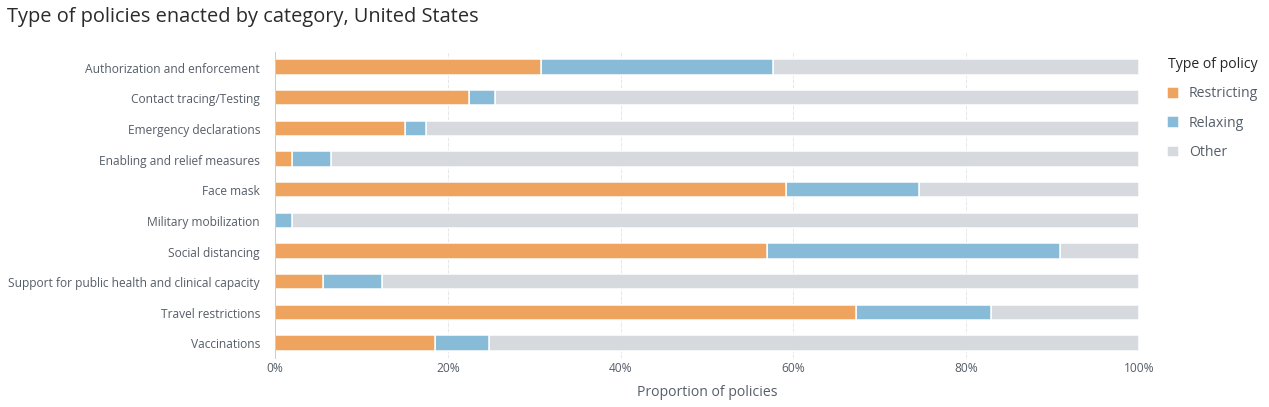

In [2176]:
# Format figure
fig, ax = plt.subplots(figsize=(figure_size))
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(False)


# Format left axis
for axis in ['left']:
    ax.spines[axis].set_color(chart[2])

# Define variables
y = us_tcat_pivot['Policy category']
x1 = us_tcat_pivot['Other']
x2 = us_tcat_pivot['Relaxing']
x3 = us_tcat_pivot['Restricting']
cats = y.unique().tolist()

# Set colors
three2 = ['#D6D9DE','#87BBD8','#EEA45F']

# Plot data
us_tcat_pivot.plot.barh(stacked=True, color=three2,width = 0.5,ax=ax)

# Changes x-axis range
ax.set_xlim(0, 1)

ax.grid(axis='x', linestyle='-.', linewidth=0.5, color=chart[2], zorder=1)

# Reverse order of axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


# Set title
title = "Type of policies enacted by category, United States"
plt.title(title, fontdict=titlefont, loc='left',x=-0.31)

# Set y-ticks
ax.set_yticklabels(cats)
ax.tick_params(axis='y',direction='out',pad=5,color=chart[1])

# Set y-axis label
plt.ylabel("")

# Format x-axis label
plt.xlabel("Proportion of policies", labelpad=10, color=chart[1],fontsize=14)
for tick in ax.get_xticklabels():
    tick.set_horizontalalignment("center")

# Format x-ticks
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0%}'.format(x) for x in current_values[::-1]])
ax.tick_params(axis='x',direction='in',length=0)


# Get the legend and modify the handles
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(1.02, 1.02), labelcolor=chart[1], labelspacing=1.2)
leg.set_title('Type of policy')
leg.get_title().set_fontsize('14')
plt.setp(plt.gca().get_legend().get_texts(), fontsize='14')

plt.tight_layout()
plt.show()

# plt.savefig('figures/us_policy_type_bar.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')


### Figure 3

#### Clean data

In [2384]:
# Drop rows with missing values in the Policy subcategory and Policy target columns
df = clean.dropna(subset=['Policy subcategory', 'Policy target'])
df = df.sort_values(by=['Policy category'])

# Create a list of unique Policy subcategories and targets
unique_categories = df['Policy subcategory'].unique()
unique_targets = set(df['Policy target'].sum())
unique_targets.discard("I don't know (MUST RESOLVE)")


# Initialize the matrix
matrix = np.zeros((len(unique_categories), len(unique_targets)))

# Count the number of occurrences of each category-target pair
for i, category in enumerate(unique_categories):
    for j, target in enumerate(unique_targets):
        for targets in df[df['Policy subcategory']==category]['Policy target']:
            if target in targets:
                matrix[i, j] += 1

# Convert the matrix to a DataFrame
df_matrix = pd.DataFrame(matrix, columns=unique_targets, index=unique_categories)


In [2238]:
df_matrix.to_csv("processed/cooccurrence_matrix.csv")

#### 3A: Heat map of subcategories and subtargets, globally

In [2358]:
# Define categories and their corresponding colors
category_colors = {
    'Adaptation and mitigation measures': 'Social distancing',
    'Event delays or cancellations': 'Social distancing',
    'Hazard pay': 'Enabling and relief measures',
    'Private sector closures': 'Social distancing',
    'School closures': 'Social distancing',
    'Public health emergency declaration': 'Emergency declarations',
    'Vaccine administration, distribution, and logistics': 'Vaccinations',
    'Mass gathering restrictions': 'Social distancing',
    'International travel restriction': 'Travel restrictions',
    'Support for telemedicine': 'Support for public health and clinical capacity',
    'Testing': 'Contact tracing/Testing',
    'Health screening': 'Social distancing',
    'Leave entitlement adjustments': 'Enabling and relief measures',
    'Medical licensing waivers': 'Support for public health and clinical capacity',
    'Quarantine': 'Social distancing',
    'Regulatory relief': 'Enabling and relief measures',
    'Enforcement': 'Authorization and enforcement',
    'Other measures to support public health and clinical capacity': 'Support for public health and clinical capacity',
    'Utility payment': 'Enabling and relief measures',
    'Relief funding': 'Enabling and relief measures',
    'Other relief measures': 'Enabling and relief measures',
    'Alternative election measures': 'Social distancing',
    'Authorization': 'Authorization and enforcement',
    'Face mask required': 'Face mask',
    'Isolation': 'Social distancing',
    'Face mask suggested': 'Face mask',
    'Distancing mandate': 'Social distancing',
    'Stay at home': 'Social distancing',
    'Visitor restrictions': 'Social distancing',
    'Safer at home': 'Social distancing',
    'Tax delay': 'Enabling and relief measures',
    'Public service closures': 'Social distancing',
    'Notification requirements': 'Support for public health and clinical capacity',
    'Emergency use or expanded market authorization': 'Support for public health and clinical capacity',
    'Other labor protections': 'Enabling and relief measures',
    'General emergency declaration': 'Emergency declarations',
    'Other forms of social distancing': 'Social distancing',
    'Anti-price gouging measures': 'Enabling and relief measures',
    'Modification of unemployment benefits': 'Enabling and relief measures',
    'Face mask exemption': 'Face mask',
    'Lockdown': 'Social distancing',
    'Remote Notarization': 'Enabling and relief measures',
    'Activation of military for logistical and/or medical support': 'Military mobilization',
    'Vaccine mandate': 'Vaccinations',
    'Support for essential workers': 'Enabling and relief measures',
    'Budget modifications': 'Enabling and relief measures',
    'Vaccine-related plan': 'Vaccinations',
    'Extension of public services': 'Enabling and relief measures',
    'Curfews': 'Social distancing',
    'Multi-vaccine policy': 'Vaccinations',
    'Vaccine cost, financing, and insurance': 'Vaccinations',
    'Domestic travel restrictions (interstate)': 'Travel restrictions',
    'Healthcare facility licensing waivers': 'Support for public health and clinical capacity',
    'Elective procedure delay or cancellation': 'Support for public health and clinical capacity',
    'Domestic travel restrictions (intrastate)':'Travel restrictions',
    'Risk Communication': 'Support for public health and clinical capacity',
    'Domestic travel restriction': 'Travel restrictions',
    'Contact tracing': 'Contact tracing/Testing',
    'Face mask (other)': 'Face mask',
    'Face covering': 'Social distancing',
    'Eviction and foreclosure delays': 'Enabling and relief measures',
    'Vaccine prioritization': 'Vaccinations',
    'Stimulus payments': 'Enabling and relief measures',
    'Crisis standards of care': 'Support for public health and clinical capacity',
    'Coverage for cost of testing': 'Support for public health and clinical capacity',
    'Prison population reduction': 'Social distancing',
    'Mortgage payment support': 'Enabling and relief measures',
    'Immunity for medical providers': 'Support for public health and clinical capacity',
    'Revised “emergency personnel” designations': 'Support for public health and clinical capacity',
    'Vaccine exemption or alternative':'Vaccinations',
    'Early prison release':'Enabling and relief measures'}

rainbow_map = {
    'Authorization and enforcement': '#1A5784',
    'Contact tracing/Testing': '#38828C',
    'Emergency declarations': '#84B5B2',
    'Enabling and relief measures':'#60904F',
    'Face mask':'#ACC253',
    'Military mobilization':'#E7C960',
    'Social distancing':'#E49243',
    'Support for public health and clinical capacity':'#D75F58',
    'Travel restrictions':'#A04275',
    'Vaccinations':'#633D71'
}


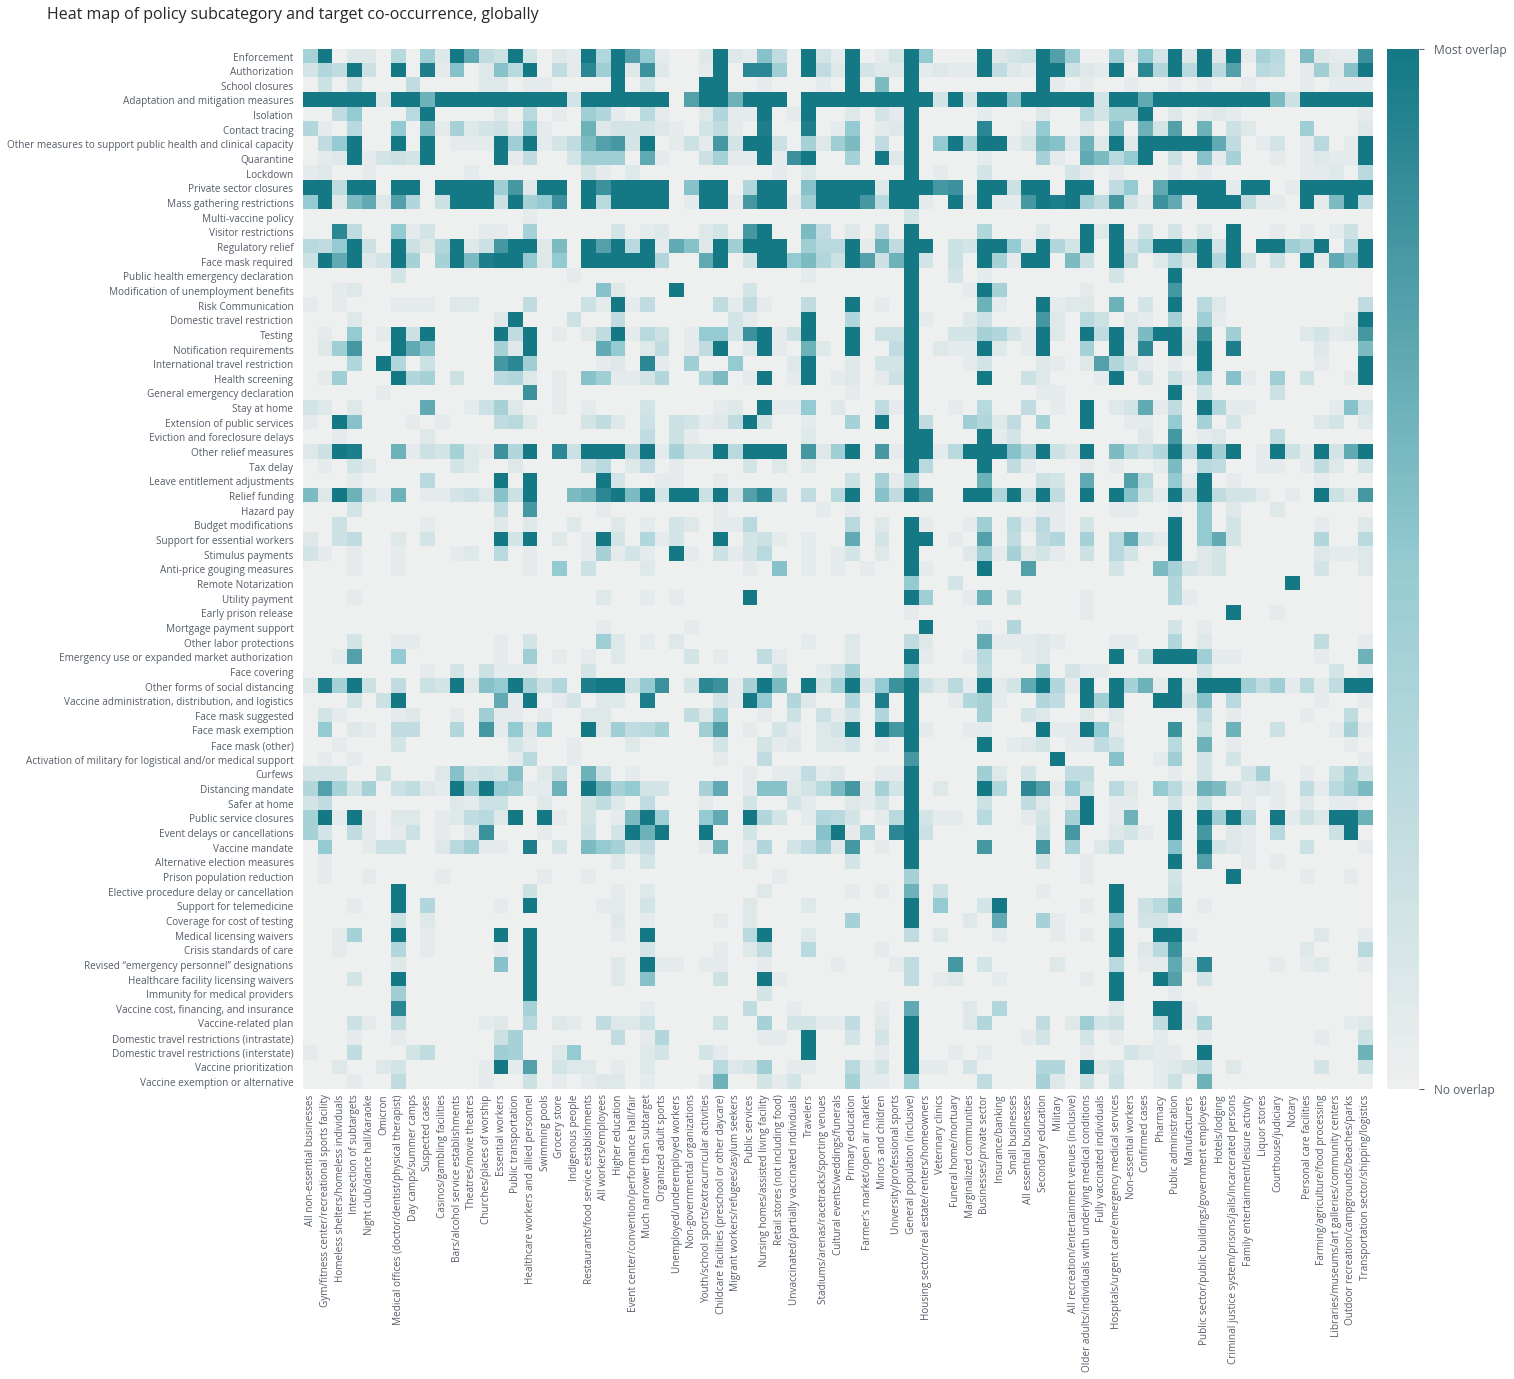

In [2386]:
fig, ax = plt.subplots(figsize=(20,20))

vmax = 20
vmin = 0

im = ax.imshow(matrix, cmap=cm, vmin=vmin, vmax=vmax)

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False,pad=20)
cbar.set_ticks([vmin,vmax])
cbar.ax.yaxis.set_ticklabels(['No overlap','Most overlap'])
cbar.ax.yaxis.set_tick_params(direction='out',length=5,width=1,pad=10,colors=chart[1],labelsize=12)
cbar.outline.set_visible(False)

# Spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set tick labels and axis labels
ax.set_xticks(range(len(unique_targets)))
ax.set_xticklabels(unique_targets)
ax.tick_params(axis='x',pad=5,length=0,labelsize=10,width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.set_yticks(range(len(unique_categories)))
ax.set_yticklabels(unique_categories)
ax.tick_params(axis='y',pad=10,width=30,labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)



# Set title and show the plot
ax.set_title("Heat map of policy subcategory and target co-occurrence, globally",fontsize=16,x=-.01)
plt.tight_layout()
plt.show()

# plt.savefig('figures/global_cat_target_heatmap.png', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')


#### 3B: Heat map of subcategories and targets, United States

In [2387]:
# Drop rows with missing values in the Policy subcategory and Policy target columns
us = clean.dropna(subset=['Policy subcategory', 'Policy target'])
us = us.loc[clean['Country']=='USA']
us = us.sort_values(by=['Policy category'])

# Create a list of unique Policy subcategories and targets
us_categories = us['Policy subcategory'].unique()
us_targets = set(us['Policy target'].sum())
us_targets.discard("I don't know (MUST RESOLVE)")


# Initialize the matrix
occur = np.zeros((len(us_categories), len(us_targets)))

# Count the number of occurrences of each category-target pair
for i, category in enumerate(us_categories):
    for j, target in enumerate(us_targets):
        for targets in us[us['Policy subcategory']==category]['Policy target']:
            if target in targets:
                occur[i, j] += 1

# Convert the matrix to a DataFrame
us_matrix = pd.DataFrame(occur, columns=us_targets, index=us_categories)


In [2388]:
us_matrix.to_csv("processed/us_cooccurrence_matrix.csv")

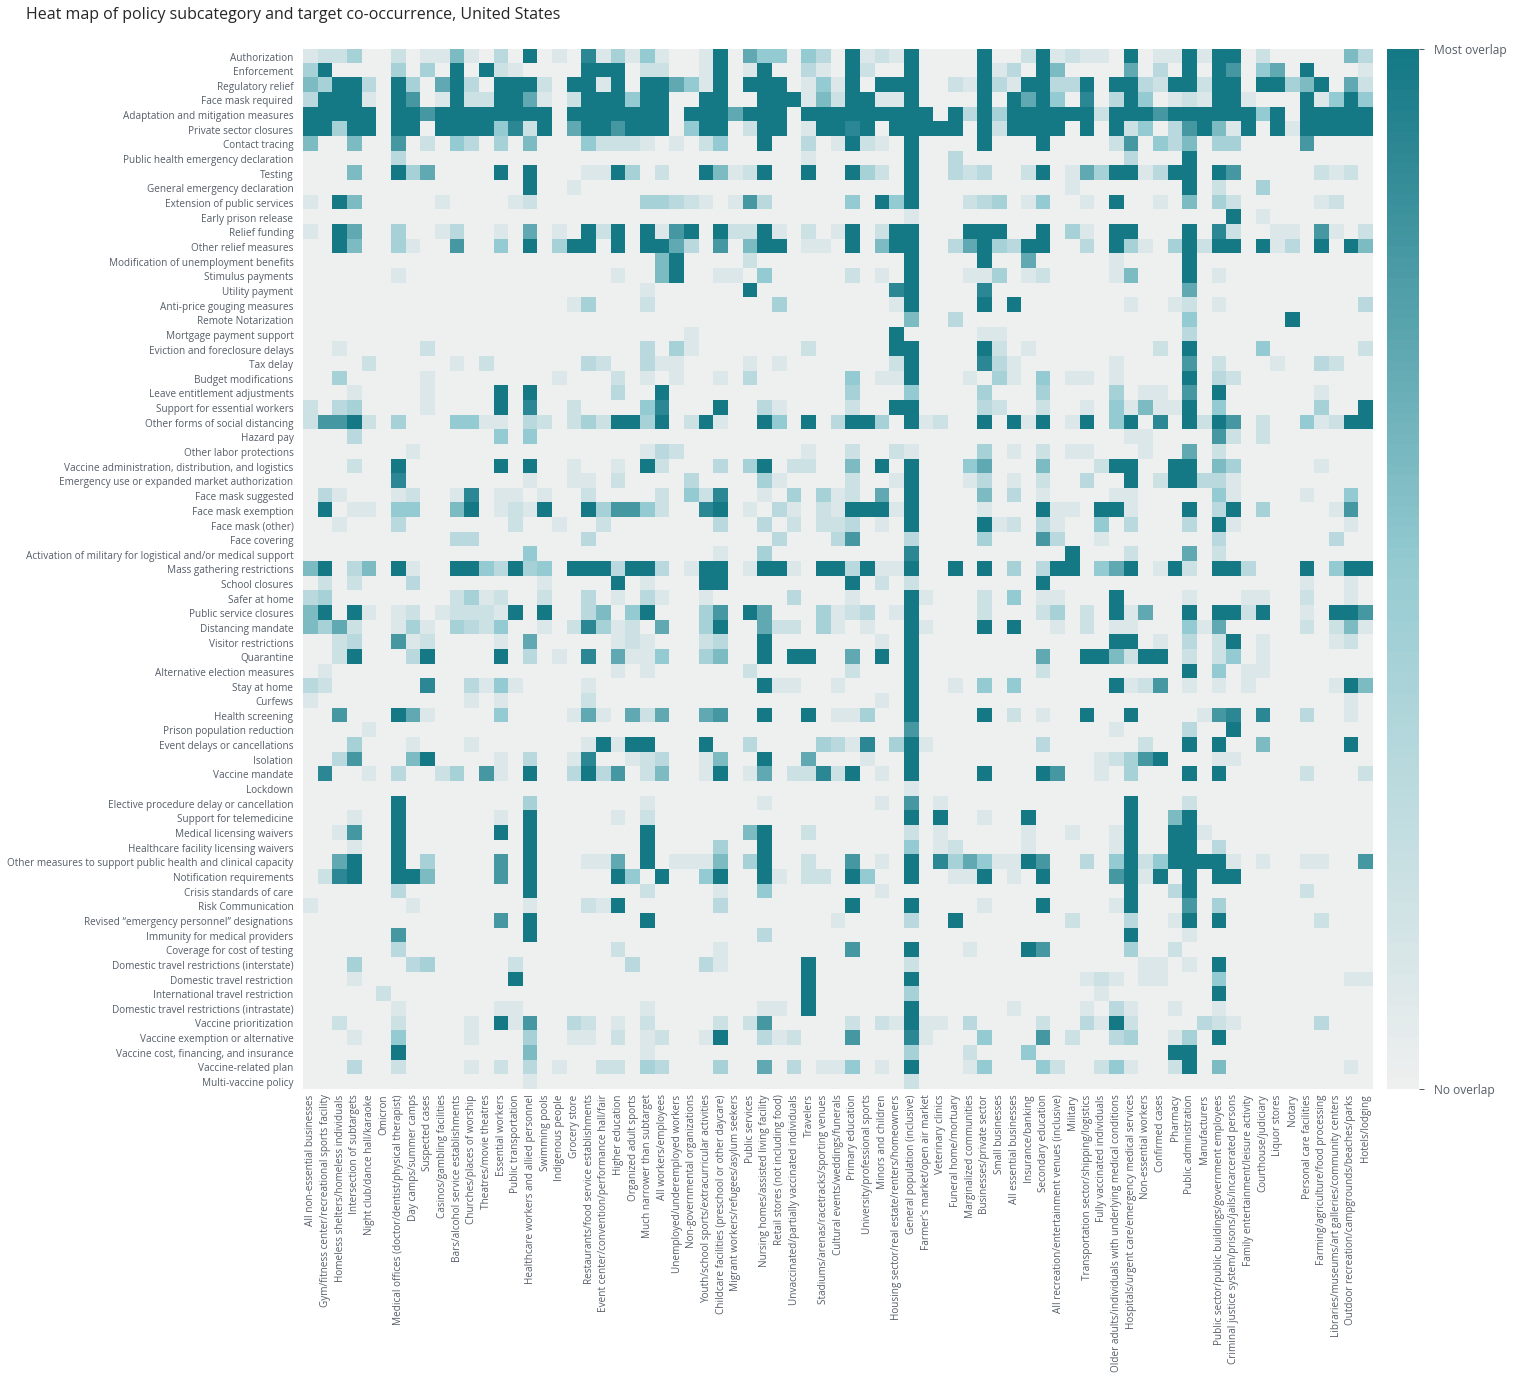

In [2395]:
fig, ax = plt.subplots(figsize=(20,20))

vmax = 10
vmin = 0

im = ax.imshow(occur, cmap=cm, vmin=vmin, vmax=vmax)

# Create a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
sm = plt.cm.ScalarMappable(cmap=cm,
                           norm=plt.Normalize(vmin=vmin,
                                              vmax=vmax))
sm._A = []
cbar = plt.colorbar(sm,cax=cax,drawedges=False,pad=20)
cbar.set_ticks([vmin,vmax])
cbar.ax.yaxis.set_ticklabels(['No overlap','Most overlap'])
cbar.ax.yaxis.set_tick_params(direction='out',length=5,width=1,pad=10,colors=chart[1],labelsize=12)
cbar.outline.set_visible(False)

# Spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set tick labels and axis labels
ax.set_xticks(range(len(us_targets)))
ax.set_xticklabels(us_targets)
ax.tick_params(axis='x',pad=5,length=0,labelsize=10,width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.set_yticks(range(len(us_categories)))
ax.set_yticklabels(us_categories)
ax.tick_params(axis='y',pad=10,width=30,labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)



# Set title and show the plot
ax.set_title("Heat map of policy subcategory and target co-occurrence, United States",fontsize=16,x=-.01)
plt.tight_layout()
plt.show()

# plt.savefig('figures/us_cat_target_heatmap.svg', dpi=1200, facecolor='w', 
#             edgecolor='w', 
#             orientation='portrait',bbox_inches='tight')
